In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, 10):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.971 (0.971)	Loss 0.6915 (0.6915)	Accuracy 0.5312 (0.5312)
Batch: [10/40]	Time 0.067 (0.152)	Loss 0.6899 (0.6978)	Accuracy 0.5156 (0.5192)
Batch: [20/40]	Time 0.448 (0.161)	Loss 0.6376 (0.6865)	Accuracy 0.6484 (0.5342)
Batch: [30/40]	Time 0.098 (0.152)	Loss 0.6800 (0.6794)	Accuracy 0.6484 (0.5650)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.707 (0.707)	Loss 0.5273 (0.5273)	Accuracy 0.6250 (0.6250)
Avg validation loss: 0.6178317985534668 	 Accuracy: 0.692
--------------------
Epoch 0/20	Time 6.844 sec (6.844 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.776 (0.776)	Loss 0.5995 (0.5995)	Accuracy 0.7188 (0.7188)
Batch: [10/40]	Time 0.036 (0.186)	Loss 0.5859 (0.6080)	Accuracy 0.6875 (0.6946)
Batch: [20/40]	Time 0.328 (0.171)	Loss 0.5556 (0.6017)	Accuracy 0.7266 (0.6830)
Batch: [30/40]	Time 0.047 (0.165)	Loss 0.5174 (0.5888)	Accuracy 0.6797 (0.6845)
----------
Test: [0/4]	Time 0.726 (0.726)	Loss 0.5777 (0.5777)	Accuracy 0.6172 (0.6172)
Avg validation loss: 0.5403427040576935 	 Accuracy: 0.696
--------------------
Epoch 1/20	Time 6.936 sec (6.890 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.748 (0.748)	Loss 0.4851 (0.4851)	Accuracy 0.7500 (0.7500)
Batch: [10/40]	Time 0.035 (0.185)	Loss 0.5539 (0.5328)	Accuracy 0.7031 (0.7102)
Batch: [20/40]	Time 0.481 (0.183)	Loss 0.4883 (0.5194)	Accuracy 0.7969 (0.7247)
Batch: [30/40]	Time 0.048 (0.168)	Loss 0.4774 (0.5058)	Accuracy 0.7656 (0.7377)
----------
Test: [0/4]	Time 0.718 (0.718)	Loss 0.4963 (0.4963)	Accuracy 0.7188 (0.7188)
Avg validation loss: 0.4667396481037

In [16]:
import matplotlib.pyplot as plt

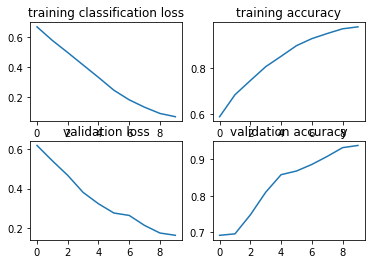

In [17]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [18]:
from synthetic_dataloader import *

In [45]:
shape_gender_train = ShapeGenderDataset(train_df)
shape_gender_val = ShapeGenderDataset(val_df)
shape_gender_test = ShapeGenderDataset(test_df)

In [46]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(train_df)):
        img, shape, color = shape_gender_train[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [47]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [48]:
import matplotlib.cm as cm
plt.style.use('bmh')

In [49]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [51]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [52]:
train_df.class_to_idx

{'circle': 0, 'rectangle': 1}

Saved to: indep_tsne_train_classifier_y.pdf


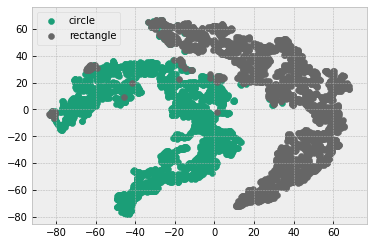

In [53]:
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
# plt.show()
out = "indep_tsne_train_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: indep_tsne_train_classifier_s.pdf


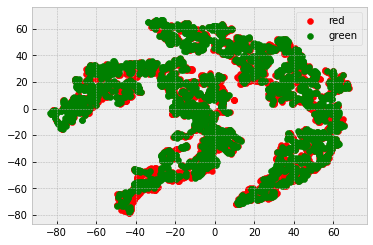

In [54]:
plt.figure()
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "indep_tsne_train_classifier_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))
# plt.show()

Saved to: indep_tsne_train_classifier_s.pdf


<Figure size 432x288 with 0 Axes>

In [31]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(test_df)):
        img, shape, color = shape_gender_test[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [32]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [33]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [34]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

Saved to: indep_tsne_test_classifier_y.pdf


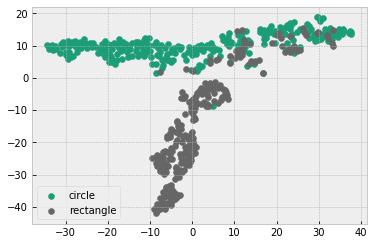

In [41]:
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
out = "indep_tsne_test_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: dep_tsne_test_classifier_y.pdf


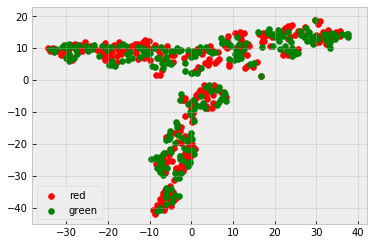

In [42]:
plt.figure()
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "dep_tsne_test_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: dep_tsne_test_classifier_y.pdf


<Figure size 432x288 with 0 Axes>